In [127]:
import numpy as np
import matplotlib as mpl
mpl.use("Agg")
from matplotlib import rc
#rc('font',**{'family':'serif'})
#rc('text', usetex=True)
from matplotlib import pyplot as plt
%matplotlib notebook

In [128]:
BENCHMARKS_DIR = 'bifrost/test/benchmarks/'
SERIAL_BENCHMARKS_DIR = BENCHMARKS_DIR + 'performance_vs_serial/'

In [142]:
ls bifrost/test/benchmarks/performance_vs_serial/

README.rst               benchmarks_ben.log.txt   linear_fft_pipeline.py
benchmarks.log.txt       benchmarks_ben2.log.txt  run_benchmark.sh*
benchmarks3.log.txt      benchmarks_ben3.log.txt  skcuda_fft_pipeline.py
benchmarks4.log.txt      benchmarks_ben4.log.txt
benchmarks5.log.txt      benchmarks_ben5.log.txt


In [143]:
benchmarks_file = open(SERIAL_BENCHMARKS_DIR + 'benchmarks_ben5.log.txt', 'r')
# FFT's/2, size multiplier, gulp size, gulp frame read, gulp frame fft, ..., ..., speedup
aws_benchmarks = np.genfromtxt(
    (",".join(ln.split(',')[1:-1]) for ln in benchmarks_file),
    dtype=np.float32,
    delimiter=',');

In [145]:
i_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': 2,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': 4,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Log2 the data, and extract a slice for plotting:

In [146]:
cur_benchmarks = np.copy(aws_benchmarks)
cur_benchmarks[:, i_map['gulp_size']] = np.log2(cur_benchmarks[:, i_map['gulp_size']]/32768)
cur_benchmarks[:, i_map['gulp_nframe_read']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_read']])
cur_benchmarks[:, i_map['gulp_nframe_fft']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_fft']])

# Create a data slice:

In [147]:
data_slice = {
    'fft_number': 1,
    'size_multiplier': 1,
    'gulp_nframe_read': np.log2(2)
}

index_possible_choices = [cur_benchmarks[:, i_map[key]] == data_slice[key] for key in data_slice.keys()]

index_shared_choices = np.bitwise_and.reduce(index_possible_choices)

indices = np.argwhere(index_shared_choices[:]) #works.

# Get ready to plot it:

In [148]:
x_axis = 'gulp_size' #second of [1, 2]
y_axis = 'gulp_nframe_fft' #first of [1, 2]

data_to_plot = cur_benchmarks[indices, [i_map[y_axis], i_map[x_axis], -1]]

range_array = lambda ar: np.max(ar) - np.min(ar)

shape_display_y = int(range_array(data_to_plot[:, 0]) + 1)
shape_display_x = int(range_array(data_to_plot[:, 1]) + 1)

# Last axis is always x-axis in an imshow!
plot_shape = (shape_display_y, shape_display_x)

display_plot = np.zeros(plot_shape)

display_plot[data_to_plot[:, 0].astype(np.int), data_to_plot[:, 1].astype(np.int)] = data_to_plot[:, 2]

# Plot the data:

<IPython.core.display.Javascript object>


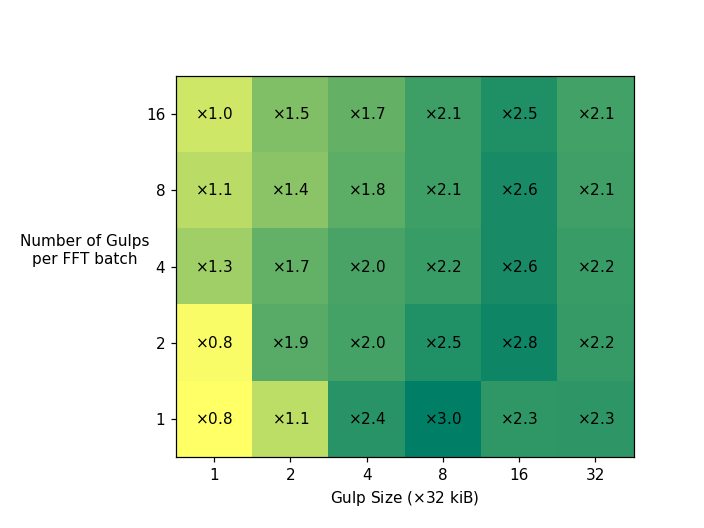

In [135]:
%matplotlib notebook

fig, ax1 = plt.subplots(1,1)
from matplotlib.colors import LogNorm

# Title:
title_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': "Gulp Size"r" ($\times$32 kiB)",
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': "Number of Gulps\nper FFT batch",
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Title:
tick_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': lambda i: 2**i,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': lambda i: 2**i,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Log color scale
norm = LogNorm(vmin=np.min(display_plot), vmax=np.max(display_plot))

im = ax1.imshow(
    display_plot,
    cmap='summer_r', origin='lower', norm=norm)
ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=40)
ax1.set_xlabel(title_map[x_axis]);

ax1.set_xticks([i for i in range(display_plot.shape[1])])
ax1.set_yticks([i for i in range(display_plot.shape[0])])
ax1.set_xticklabels([tick_map[x_axis](i) for i in range(display_plot.shape[1])])
ax1.set_yticklabels([tick_map[y_axis](i) for i in range(display_plot.shape[0])])

"""
ax1.set_xticks([i for i in range(5)])
ax1.set_xticklabels([2**i for i in range(1, 6)])
ax1.set_xlabel(r'Gulp Size ($\times$128 kiB)')
ax1.set_yticks([0, 1, 2, 3, 4])
ax1.set_yticklabels([1, 2, 4, 8, 16])
ax1.set_ylabel(r'Number Gulps''\n'r'per batch',rotation=0, labelpad=40)
cbar = fig.colorbar(im, shrink=0.4, ticks=[np.min(rel_display_plot), 1.0, 2])
cbar.ax.set_yticklabels(['Slower', 'Same', 'Faster'])  # vertically oriented colorbar
cbar.ax.text(13, 0.4, 'Speedup\nvs.\nskcuda', rotation=0, 
        horizontalalignment='center')

fig.savefig('bifrost/speedup.pdf', bbox_inches='tight')
""";

for (j,i),label in np.ndenumerate(display_plot):
    ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center')
fig.subplots_adjust(left=0.25)

# Functions:

In [149]:
title_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': "Gulp Size"r" ($\times$32 kiB)",
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': "Number of Gulps\nper FFT batch",
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

# Title:
tick_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': lambda i: 2**i,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': lambda i: 2**i,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

i_map = {
    'fft_number': 0,
    'size_multiplier': 1,
    'gulp_size': 2,
    'gulp_nframe_read': 3,
    'gulp_nframe_fft': 4,
    'bf_time': 5,
    'sk_time': 6,
    'speedup': 7
}

def clean_array(array):
    cur_benchmarks = np.copy(array)
    cur_benchmarks[:, i_map['gulp_size']] = np.log2(cur_benchmarks[:, i_map['gulp_size']]/32768)
    cur_benchmarks[:, i_map['gulp_nframe_fft']] = np.log2(cur_benchmarks[:, i_map['gulp_nframe_fft']])
    
    return cur_benchmarks

def create_slice(dict_slice, array):
    index_possible_choices = [array[:, i_map[key]] == data_slice[key] for key in data_slice.keys()]
    index_shared_choices = np.bitwise_and.reduce(index_possible_choices)
    indices = np.argwhere(index_shared_choices[:]) #works.
    
    return indices

def extract_data(indices, x_axis, y_axis, array):
    data_to_plot = np.copy(array[indices, [i_map[y_axis], i_map[x_axis], -1]])
    range_array = lambda ar: np.max(ar) - np.min(ar)
    shape_display_y = int(range_array(data_to_plot[:, 0]) + 1)
    shape_display_x = int(range_array(data_to_plot[:, 1]) + 1)
    # Last axis is always x-axis in an imshow!
    plot_shape = (shape_display_y, shape_display_x)
    display_plot = np.zeros(plot_shape)
    display_plot[data_to_plot[:, 0].astype(np.int), data_to_plot[:, 1].astype(np.int)] = data_to_plot[:, 2]
    
    return display_plot


# Experiment:

In [150]:
plt.subplots?

<IPython.core.display.Javascript object>


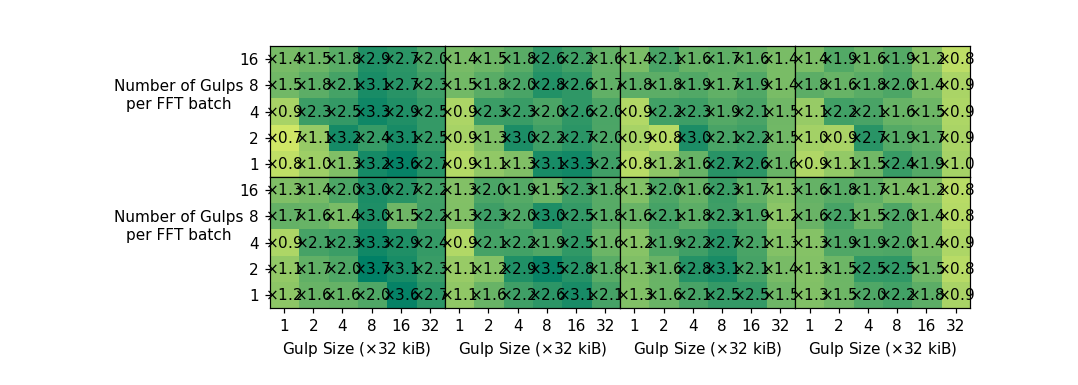

In [211]:
%matplotlib notebook
# Log color scale
norm = LogNorm(vmin=np.min(aws_benchmarks[:,-1]), vmax=np.max(aws_benchmarks[:,-1]))

fig = plt.figure(figsize = np.array([7*2,5])*0.7)


for ax in range(8):
    ax1 = {
        0: plt.subplot(2,4,1), #top left
        1: plt.subplot(2,4,2), #middle top left
        2: plt.subplot(2,4,5), #bottom left
        3: plt.subplot(2,4,6), #middle bottom left
        4: plt.subplot(2,4,3), #middle top right
        5: plt.subplot(2,4,4), #top right
        6: plt.subplot(2,4,7), #middle bottom right
        7: plt.subplot(2,4,8), #bottom right
    }[ax]
    
    # Top of plots are FFT=2, bottom is FFT=1 (total blocks)
    # from left to right, number of gulps in nframe read increases
    data_slice = {
        'fft_number': {0:2, 2:1,
                       1:2, 3:1,
                       4:2, 6:1,
                       5:2, 7:1}[ax],
        'size_multiplier': 1,
        'gulp_nframe_read': {0:2, 2:2,
                             1:4, 3:4,
                             4:8, 6:8,
                             5:16, 7:16}[ax],
    }
    x_axis = 'gulp_size'
    y_axis = 'gulp_nframe_fft'

    cur_benchmarks = clean_array(aws_benchmarks)
    indices = create_slice(data_slice, cur_benchmarks)
    display_plot = extract_data(indices, x_axis, y_axis, cur_benchmarks)
    
    
    im = ax1.imshow(
        display_plot,
        cmap='summer_r', origin='lower', norm=norm)

    for (j,i),label in np.ndenumerate(display_plot):
        ax1.text(i, j, r'$\times$%.1f'%label, ha='center', va='center')
    if ax == 2:
        ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=40)
        ax1.set_xlabel(title_map[x_axis]);
        ax1.set_xticks([i for i in range(display_plot.shape[1])])
        ax1.set_yticks([i for i in range(display_plot.shape[0])])
        ax1.set_xticklabels([tick_map[x_axis](i) for i in range(display_plot.shape[1])])
        ax1.set_yticklabels([tick_map[y_axis](i) for i in range(display_plot.shape[0])])
    elif ax == 0:
        ax1.set_ylabel(title_map[y_axis], rotation=0, labelpad=40)
        ax1.set_yticks([i for i in range(display_plot.shape[0])])
        ax1.set_yticklabels([tick_map[y_axis](i) for i in range(display_plot.shape[0])])
        ax1.set_xticks([])
    elif ax == 3 or ax == 6 or ax == 7:
        ax1.set_xlabel(title_map[x_axis]);
        ax1.set_xticks([i for i in range(display_plot.shape[1])])
        ax1.set_xticklabels([tick_map[x_axis](i) for i in range(display_plot.shape[1])])
        ax1.set_yticks([])
    else:
        ax1.set_xticks([])
        ax1.set_yticks([])

    ax1.set_aspect('auto')

#fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)
#gs1.update(wspace=0, hspace=0) # set the spacing between axes. 

fig.subplots_adjust(left=0.25, bottom=0.2)

# Caption ideas

Should emphasize:
- This pipeline was not tuned in any way, it is vanilla Bifrost code, with no core bindings set, and no block fusion enabled.
- Not only do you get more speed for same effort, but you get greater functionality for same effort (bf.map!)
- Easy to switch it to a real-time pipeline for a telescope
- These plots aren't meant to show anything particular about when Bifrost is useful and when it isn't, they are supposed to show the trend of where Bifrost becomes very effective: large gulp sizes and large amounts of data.
- Bottom slower for Bifrost because of the greater Python overhead incurred from small gulp sizes. Small effort tuning gulp sizes eliminates this.
- Both pipelines are GPU-based FFT pipelines, controlled in Python. Similar (say exactly) source lines of code. Through pipeline-parallelism, Bifrost achieves a speedup using the same underlying cuFFT functionality.
- Emphasize that a hand-tuned C or C++ pipeline compiled with optimization can be faster than Bifrost. However, due to the development effort associated with writing a stream-processing pipeline by hand, Bifrost is a competitive alternative.

# For testing, let's see what a parallel axis figure looks like:

In [192]:
import pandas as pd
from pandas.plotting import parallel_coordinates

In [193]:
pd_data = pd.DataFrame(data=np.copy(cur_benchmarks),
             columns="FFT's/2,size multiplier,gulp size,gulp frame read,gulp frame fft,bifrost time,skcuda time,speedup".split(','),
             index=[i for i in range(cur_benchmarks.shape[0])]);

In [194]:
pd_data

,FFT's/2,size multiplier,gulp size,gulp frame read,gulp frame fft,bifrost time,skcuda time,speedup
0,1.0,1.0,4.0,1.0,0.0,0.075677,0.288693,3.81479
1,1.0,1.0,3.0,2.0,1.0,0.076838,0.287357,3.73977
2,1.0,1.0,4.0,2.0,0.0,0.080140,0.292252,3.64676
3,2.0,1.0,4.0,2.0,0.0,0.086074,0.312175,3.62682
4,1.0,1.0,3.0,4.0,1.0,0.084135,0.297993,3.54184
5,2.0,1.0,4.0,1.0,1.0,0.077985,0.265849,3.40898
6,2.0,1.0,3.0,2.0,2.0,0.078165,0.261144,3.34093
7,1.0,1.0,3.0,2.0,2.0,0.074473,0.245659,3.29863
8,2.0,1.0,4.0,4.0,0.0,0.096369,0.315315,3.27195
9,2.0,1.0,3.0,1.0,0.0,0.127512,0.408795,3.20593


In [78]:
pd_data = pd.DataFrame(data=np.copy(cur_benchmarks),
             columns="FFT's/2,size multiplier,gulp size,gulp frame read,gulp frame fft,bifrost time,skcuda time,speedup".split(','),
             index=[i for i in range(cur_benchmarks.shape[0])]);
#del pd_data['size multiplier']
#del pd_data['bifrost time']
#del pd_data['skcuda time']
#del pd_data["FFT's/2"]
up = 0.07
pd_data['gulp size'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data['gulp frame fft'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data['gulp frame read'][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up
pd_data["FFT's/2"][:] += (pd_data['speedup'][:]-np.average(pd_data['speedup']))*up

In [116]:
pd_data['bifrost time']

0      0.194302
1      0.151432
2      0.138624
3      0.140589
4      0.147184
5      0.159194
6      0.203691
7      0.159232
8      0.152472
9      0.141238
10     0.154043
11     0.153326
12     0.160580
13     0.153858
14     0.155721
15     0.160679
16     0.160253
17     0.305138
18     0.155020
19     0.161168
20     0.155212
21     0.153911
22     0.195915
23     0.181188
24     0.156572
25     0.185818
26     0.155183
27     0.232920
28     0.165115
29     0.232575
         ...   
270    0.807545
271    0.806579
272    0.805889
273    1.038048
274    0.630322
275    0.613329
276    0.687521
277    0.843118
278    0.590009
279    0.600071
280    0.610636
281    0.587458
282    0.896152
283    0.590387
284    0.610913
285    0.594312
286    1.188587
287    0.636180
288    0.945968
289    0.886370
290    0.602740
291    0.956071
292    0.994764
293    1.044367
294    1.488309
295    1.522324
296    1.527810
297    1.575998
298    1.195006
299    1.719387
Name: bifrost time, Leng

In [124]:
colors = [[1.0-i/3.0, i/3.0, 0.0, 0.5] for i in pd_data['speedup']]
#colors = [[i[0], i[1], (-1.*np.min(pd_data['gulp size']) + pd_data['gulp size'][x]/6.0)/2.0, 0.2] for x,i in enumerate(colors)]

<IPython.core.display.Javascript object>


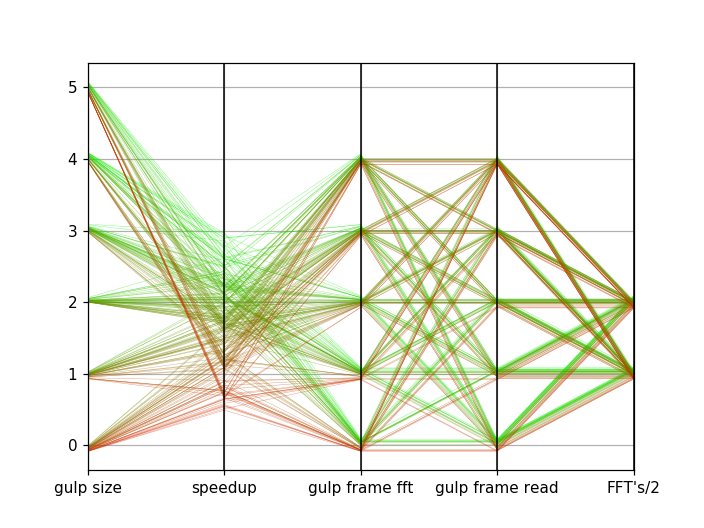

In [126]:
fig = plt.figure()
parallel_coordinates(pd_data,
                     "speedup",
                     cols="gulp size,speedup,gulp frame fft,gulp frame read,FFT's/2".split(','),
                     color=colors,
                     linewidth=0.3)
plt.gca().legend_.remove()
fig.savefig("parallel.pdf")

In [83]:
parallel_coordinates?